In [44]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
train_spread = pd.read_csv("train_spread.csv", index_col=0)
train_spread_base = pd.read_csv("train_spread_base.csv", index_col=0)
train_z_score = pd.read_csv("train_z_score.csv", index_col=0) # 2012/01/30+
train_spread = train_spread.iloc[18:,:] # Resccale to 2012/01/30+
train_spread_base = train_spread_base.iloc[18:,:] # Resccale to 2012/01/30+

### ORCL GOOGL Testing

In [45]:
pair_name = train_z_score.columns[0]
z_score = train_z_score[pair_name]
spread = train_spread.iloc[:,0]
base = train_spread_base.iloc[:,0]

entryZscore, exitZscore =  [0.8, -0.05]
PnL = pd.DataFrame({f"{pair_name}(Z_score)": z_score,f"{pair_name}(Spread)": spread})
PnL.index = pd.to_datetime(z_score.index)
PnL['long entry'] = (PnL[f"{pair_name}(Z_score)"] < (-entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (-entryZscore))
PnL['long exit'] = (PnL[f"{pair_name}(Z_score)"] > (-exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (-exitZscore))
PnL['num units long'] = np.nan
PnL.loc[PnL['long entry'],'num units long'] = 1 
PnL.loc[PnL['long exit'],'num units long'] = 0 
PnL['num units long'][0] = 0 
PnL['num units long'] = PnL['num units long'].fillna(method='pad')
        
PnL['short entry'] = (PnL[f"{pair_name}(Z_score)"] > (entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (entryZscore))
PnL['short exit'] = (PnL[f"{pair_name}(Z_score)"] < (exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (exitZscore))
PnL['num units short'] = np.nan
PnL.loc[PnL['short entry'],'num units short'] = -1
PnL.loc[PnL['short exit'],'num units short'] = 0
PnL['num units short'][0] = 0 
PnL['num units short'] = PnL['num units short'].fillna(method='pad')

PnL['numUnits'] = PnL['num units long'] + PnL['num units short']
PnL['spread pct ch'] = ((spread - spread.shift(1)) / base).values
PnL['port rets'] = PnL['spread pct ch'] * PnL['numUnits'].shift(1)
PnL['cum rets'] = PnL['port rets'].cumsum()
PnL['cum rets'] = PnL['cum rets'] + 1
end_val = PnL['cum rets'].iat[-1]

In [46]:
PnL

,ORCL GOOGL(Z_score),ORCL GOOGL(Spread),long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Index,,,,,,,,,,,,
2012-01-30,-1.043321,-0.576142,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2012-01-31,-0.126136,-0.203529,False,False,0.0,False,False,0.0,0.0,0.012744,0.000000,1.000000
2012-02-01,-0.165221,-0.428311,False,False,0.0,False,False,0.0,0.0,-0.007620,-0.000000,1.000000
2012-02-02,-0.204243,-0.191858,False,False,0.0,False,False,0.0,0.0,0.008022,0.000000,1.000000
2012-02-03,-0.244408,0.011265,False,False,0.0,False,False,0.0,0.0,0.006808,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,1.902115,5.183640,False,False,0.0,False,False,-1.0,-1.0,-0.002987,0.002987,2.734654
2021-08-02,1.893876,4.255334,False,False,0.0,False,False,-1.0,-1.0,-0.003497,0.003497,2.738151
2021-08-03,1.844889,1.700487,False,False,0.0,False,False,-1.0,-1.0,-0.009478,0.009478,2.747629


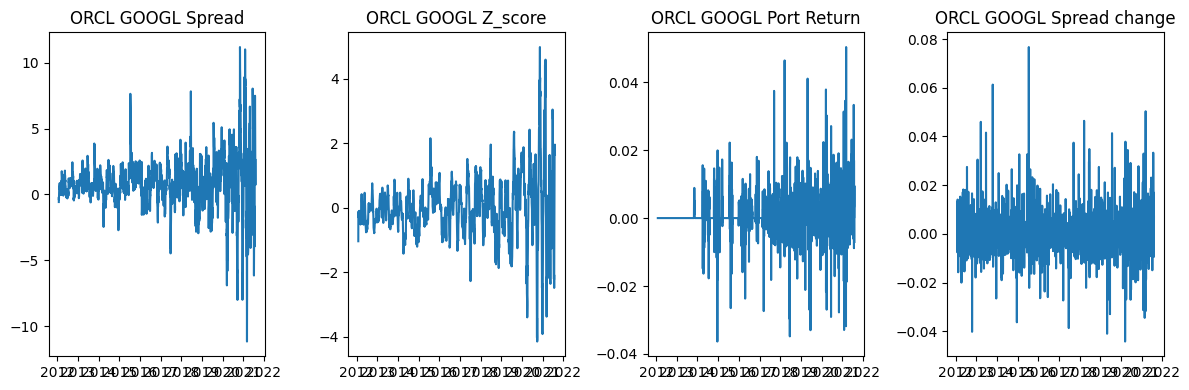

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axs[0].plot(PnL["ORCL GOOGL(Spread)"])
axs[0].set_title("ORCL GOOGL Spread")
axs[1].plot(PnL["ORCL GOOGL(Z_score)"])
axs[1].set_title("ORCL GOOGL Z_score")
axs[2].plot(PnL["port rets"])
axs[2].set_title("ORCL GOOGL Port Return")
axs[3].plot(PnL["spread pct ch"])
axs[3].set_title("ORCL GOOGL Spread change")

plt.tight_layout()
plt.show()

In [62]:
pair_name = train_z_score.columns[0]
z_score = train_z_score[pair_name]
spread = train_spread.iloc[:,0]
base = train_spread_base.iloc[:,0]
params = [-0.7, 0.05, 0.7, -0.05]
backtest(spread, z_score, base, pair_name)

(2.964470989749722,
 -0.6647731047868726,
 0.050268392413854564,
 0.7356254628300672,
 -0.04628191903233528)

## Optimzation

In [60]:
def objective(params, spread, z_score, base, pair_name):
    long_entryZscore, long_exitZscore, short_entryZscore, short_exitZscore =  params
    PnL = pd.DataFrame({f"{pair_name}(Z_score)": z_score,f"{pair_name}(Spread)": spread})
    PnL.index = pd.to_datetime(z_score.index)
    PnL['long entry'] = (PnL[f"{pair_name}(Z_score)"] < (long_entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (long_entryZscore))
    PnL['long exit'] = (PnL[f"{pair_name}(Z_score)"] > (long_exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (long_exitZscore))
    PnL['num units long'] = np.nan
    PnL.loc[PnL['long entry'],'num units long'] = 1 
    PnL.loc[PnL['long exit'],'num units long'] = 0 
    PnL['num units long'][0] = 0 
    PnL['num units long'] = PnL['num units long'].fillna(method='pad')
            
    PnL['short entry'] = (PnL[f"{pair_name}(Z_score)"] > (short_entryZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) < (short_entryZscore))
    PnL['short exit'] = (PnL[f"{pair_name}(Z_score)"] < (short_exitZscore)) & (PnL[f"{pair_name}(Z_score)"].shift(1) > (short_exitZscore))
    PnL['num units short'] = np.nan
    PnL.loc[PnL['short entry'],'num units short'] = -1
    PnL.loc[PnL['short exit'],'num units short'] = 0
    PnL['num units short'][0] = 0 
    PnL['num units short'] = PnL['num units short'].fillna(method='pad')
    
    PnL['numUnits'] = PnL['num units long'] + PnL['num units short']
    PnL['spread pct ch'] = ((spread - spread.shift(1)) / base).values
    PnL['port rets'] = PnL['spread pct ch'] * PnL['numUnits'].shift(1)
    PnL['cum rets'] = PnL['port rets'].cumsum()
    PnL['cum rets'] = PnL['cum rets'] + 1
    end_val = PnL['cum rets'].iat[-1]
    return(-end_val)

In [61]:
def backtest(spread, z_score, base, pair_name):
    result = minimize(objective, [-0.7, 0.05, 0.7, -0.05], args=(spread, z_score, base, pair_name), bounds=[(-1.1, 1.1), (-1.1, 1.1), (-1.1, 1.1), (-1.1, 1.1)], method='Nelder-Mead')
    long_entryZscore, long_exitZscore, short_entryZscore, short_exitZscore = result.x
    best_return = -result.fun
    return best_return, long_entryZscore, long_exitZscore, short_entryZscore, short_exitZscore

In [63]:
optim_table = pd.DataFrame(index=range(train_z_score.shape[1]), 
                           columns=["MaxProfit", "long_entryZscore", "long_exitZscore", "short_entryZscore", "short_exitZscore"])
optim_table.index = train_z_score.columns

for pair in range(train_z_score.shape[1]):
    pair_name = train_z_score.columns[pair]
    z_score = train_z_score[pair_name]
    spread = train_spread.iloc[:,pair]
    base = train_spread_base.iloc[:,pair]
    optim_table.iloc[pair,:] = backtest(spread, z_score, base, pair_name)

optim_table

,MaxProfit,long_entryZscore,long_exitZscore,short_entryZscore,short_exitZscore
ORCL GOOGL,2.964471,-0.664773,0.050268,0.735625,-0.046282
USLV GLD,5.932841,-0.72478,0.057938,0.420411,-0.054521
USLV AAPL,7.173641,-0.409841,0.059464,0.737689,-0.053158
USLV GOOGL,7.926474,-0.812031,0.075921,0.030073,-0.051942
USLV AMD,5.738268,-0.327198,0.056442,0.819756,-0.064161
...,...,...,...,...,...
CMCSA VDC,3.108313,-0.616941,0.055844,0.598279,-0.053717
CMCSA KXI,3.509426,0.064196,0.055354,0.345365,-0.08867
CMCSA VHT,2.66107,-0.647945,0.053769,0.705584,-0.050185
CMCSA VNQ,3.243367,-0.559886,0.052759,0.737989,-0.053155


In [65]:
optim_table.to_csv('z_score_optim.csv', index=True)